# Generating defects with `doped`

If you are new to computational modelling of defects, it is highly recommended that you watch the [defect calculations tutorial](https://youtu.be/FWz7nm9qoNg) by Seán and Joe on YouTube. This gives a brief overview of much of the theory and rationale behind our typical defect calculation workflow.

In this tutorial we show how to generate defects and `VASP` input files with `doped`, and also perform
the recommended `ShakeNBreak` structure-searching step at the beginning of the defect workflow.
The table of contents of this tutorial is shown in the left-hand sidebar, and you can click on any of the
links to jump to that section.

## Defect Generation

In [1]:
from pymatgen.core.structure import Structure
from doped.generation import DefectsGenerator

In [2]:
# Load our relaxed bulk (host) structure:
relaxed_primitive_CdTe = Structure.from_file("CdTe/relaxed_primitive_POSCAR")

# generate defects:
defect_gen = DefectsGenerator(relaxed_primitive_CdTe)

Generating DefectEntry objects: 100.0%|██████████| [00:01,  59.32it/s]

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  ---------------  -------------------  ---------
v_Cd         [-2,-1,0,+1]     [0.000,0.000,0.000]  4a
v_Te         [-1,0,+1,+2]     [0.250,0.250,0.250]  4c

Substitutions    Guessed Charges          Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_Te            [0,+1,+2,+3,+4]        [0.250,0.250,0.250]  4c
Te_Cd            [-4,-3,-2,-1,0,+1,+2]  [0.000,0.000,0.000]  4a

Interstitials    Guessed Charges          Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_i_C3v         [0,+1,+2]              [0.625,0.625,0.625]  16e
Cd_i_Td_Cd2.83   [0,+1,+2]              [0.750,0.750,0.750]  4d
Cd_i_Td_Te2.83   [0,+1,+2]              [0.500,0.500,0.500]  4b
Te_i_C3v         [-2,-1,0,+1,+2,+3,+4]  [0.625,0.625,0.625]  16e
Te_i_Td_Cd2.83   [-2,-1,0,+1,+2,+3,+4]  [0.750,0.750,0.750]  4d
Te_i_Td_Te2.83   [-2,-1,0,+1,+2,+3

The `DefectsGenerator` class is used to generate defects with `doped`.
It has been set up to adopt reasonable defaults, such as supercell generation (tries to find the smallest possible supercell which is at least 10 Å in each direction; a typical threshold for minimising finite-size effects) and defect charge state guessing, but these are fully customisable using the class options shown in the docstring below.
By default, defects are placed at the closest possible symmetry-equivalent site to the midpoint of the supercell, to aid visualisation e.g. in `VESTA`.

```{important}
As always with defect studies, you should carefully consider whether the default settings are appropriate for your system, and if not, you should customise them accordingly.

Some typical reasons for customising the default settings include:
- **Guessed Charges**: The `doped` charge-state guessing algorithm has been developed to try balance
efficiency (avoiding unnecessary calculations) and completeness (avoiding missing out on important
defect species). However often defects behave in ways that we mightn't expect at first (part of what makes  them interesting!) and so no algorithm is able to predict exactly which charge states will/won't be
stable for your system. So, you should consider if your system is likely to have any unusual charge
states (e.g. common in systems with low-symmetry (e.g. [Sb₂Se₃](https://arxiv.org/abs/2302.04901)),
defect reconstructions (e.g. [Sb₂S₃](https://www.nature.com/articles/s41524-023-00973-1)
& [Al₂O₃](https://doi.org/10.1088/1361-648X/acd3cf) and/or amphoteric species (e.g. [CdTe](https://doi.org/10.1039/D2FD00043A))) and if so, you should update the charge state ranges of your defects
accordingly (example shown below).
- **Target Supercell**: You may want to use a specific supercell for your calculations, perhaps to
reproduce or build on calculations from a previous study with a specific supercell.
```

In [12]:
# run this to see the function documentation:
DefectsGenerator?

Init signature:
DefectsGenerator(
    structure: pymatgen.core.structure.Structure,
    extrinsic: Union[str, List, Dict, NoneType] = None,
    interstitial_coords: Optional[List] = None,
    generate_supercell: bool = True,
    charge_state_gen_kwargs: Optional[Dict] = None,
    supercell_gen_kwargs: Optional[Dict] = None,
    interstitial_gen_kwargs: Optional[Dict] = None,
    target_frac_coords: Optional[List] = None,
    processes: Optional[int] = None,
)
Docstring:      Class for generating doped DefectEntry objects.
Init docstring:
Generates doped DefectEntry objects for defects in the input host
structure. By default, generates all intrinsic defects, but extrinsic
defects (impurities) can also be created using the `extrinsic`
argument.

Interstitial sites are generated using Voronoi tessellation by default (found
to be the most reliable), which can be controlled using the
`interstitial_gen_kwargs` argument (passed as keyword arguments to the
`VoronoiInterstitialGenerator` class)

Information about the generated defects and supercell is accessible using the `DefectsGenerator`
attributes, like `defect_entries`, `bulk_supercell`, `defects` etc.

```{note}
**Note:**
The algorithm for determining defect entry names is to use the pymatgen defect
name (e.g. `v_Cd`, `Cd_Te` etc.) for vacancies/antisites/substitutions, unless
there are multiple inequivalent sites for the defect, in which case the point
group of the defect site is appended (e.g. `v_Cd_Td`, `Cd_Te_Td` etc.), and if
this is still not unique, then element identity and distance to the nearest
neighbour of the defect site is appended (e.g. `v_Cd_Td_Te2.83`, `Cd_Te_Td_Cd2.83`
etc.). For interstitials, the same naming scheme is used, but the point group
is always appended to the pymatgen defect name.
```

In [3]:
# show the generated defect entries:
defect_gen.defect_entries.keys()

dict_keys(['v_Cd_-2', 'v_Cd_-1', 'v_Cd_0', 'v_Cd_+1', 'v_Te_-1', 'v_Te_0', 'v_Te_+1', 'v_Te_+2', 'Cd_Te_0', 'Cd_Te_+1', 'Cd_Te_+2', 'Cd_Te_+3', 'Cd_Te_+4', 'Te_Cd_-4', 'Te_Cd_-3', 'Te_Cd_-2', 'Te_Cd_-1', 'Te_Cd_0', 'Te_Cd_+1', 'Te_Cd_+2', 'Cd_i_C3v_0', 'Cd_i_C3v_+1', 'Cd_i_C3v_+2', 'Cd_i_Td_Cd2.83_0', 'Cd_i_Td_Cd2.83_+1', 'Cd_i_Td_Cd2.83_+2', 'Cd_i_Td_Te2.83_0', 'Cd_i_Td_Te2.83_+1', 'Cd_i_Td_Te2.83_+2', 'Te_i_C3v_-2', 'Te_i_C3v_-1', 'Te_i_C3v_0', 'Te_i_C3v_+1', 'Te_i_C3v_+2', 'Te_i_C3v_+3', 'Te_i_C3v_+4', 'Te_i_Td_Cd2.83_-2', 'Te_i_Td_Cd2.83_-1', 'Te_i_Td_Cd2.83_0', 'Te_i_Td_Cd2.83_+1', 'Te_i_Td_Cd2.83_+2', 'Te_i_Td_Cd2.83_+3', 'Te_i_Td_Cd2.83_+4', 'Te_i_Td_Te2.83_-2', 'Te_i_Td_Te2.83_-1', 'Te_i_Td_Te2.83_0', 'Te_i_Td_Te2.83_+1', 'Te_i_Td_Te2.83_+2', 'Te_i_Td_Te2.83_+3', 'Te_i_Td_Te2.83_+4'])

If we wanted to manually add some extra charge states (e.g. some negative charge states for `Cd_Te`), we
 can do so using the `add_charge_states` method:

In [4]:
# Add some extra charge states for Cd_Te antisites
defect_gen.add_charge_states("Cd_Te", [-2, -1])

In [5]:
# check our generated defect entries:
defect_gen

DefectsGenerator for input composition CdTe, space group F-43m with 52 defect entries created.
---------------------------------------------------------
Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  ---------------  -------------------  ---------
v_Cd         [-2,-1,0,+1]     [0.000,0.000,0.000]  4a
v_Te         [-1,0,+1,+2]     [0.250,0.250,0.250]  4c

Substitutions    Guessed Charges          Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_Te            [0,+1,+2,+3,+4,-2,-1]  [0.250,0.250,0.250]  4c
Te_Cd            [-4,-3,-2,-1,0,+1,+2]  [0.000,0.000,0.000]  4a

Interstitials    Guessed Charges          Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_i_C3v         [0,+1,+2]              [0.625,0.625,0.625]  16e
Cd_i_Td_Cd2.83   [0,+1,+2]              [0.750,0.750,0.750]  4d
Cd_i_Td_Te2.83   [0,+1,+2]              [0.500,0.500,0.500]  4b
Te_i_C3v  

We see that `-2` and `-1` charge states have now been added for our Cd-on-Te antisite substitution.
Again, the help documentation for this function can be viewed with by adding a question mark to the function/method name:

In [6]:
defect_gen.add_charge_states?

Signature: defect_gen.add_charge_states(defect_entry_name: str, charge_states: list)
Docstring:
Add additional `DefectEntry`s with the specified charge states to
`self.defect_entries`.

Args:
    defect_entry_name (str):
        Name of defect entry to add charge states to.
        Doesn't need to include the charge state.
    charge_states (list): List of charge states to add to defect entry (e.g. [-2, -3]).
File:      ~/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Bread/Projects/Packages/doped/doped/generation.py
Type:      method

In [7]:
# likewise we can remove charge states with:
defect_gen.remove_charge_states("v_Cd", [+1])
defect_gen

DefectsGenerator for input composition CdTe, space group F-43m with 51 defect entries created.
---------------------------------------------------------
Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  ---------------  -------------------  ---------
v_Cd         [-2,-1,0]        [0.000,0.000,0.000]  4a
v_Te         [-1,0,+1,+2]     [0.250,0.250,0.250]  4c

Substitutions    Guessed Charges          Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_Te            [0,+1,+2,+3,+4,-2,-1]  [0.250,0.250,0.250]  4c
Te_Cd            [-4,-3,-2,-1,0,+1,+2]  [0.000,0.000,0.000]  4a

Interstitials    Guessed Charges          Conv. Cell Coords    Wyckoff
---------------  ---------------------  -------------------  ---------
Cd_i_C3v         [0,+1,+2]              [0.625,0.625,0.625]  16e
Cd_i_Td_Cd2.83   [0,+1,+2]              [0.750,0.750,0.750]  4d
Cd_i_Td_Te2.83   [0,+1,+2]              [0.500,0.500,0.500]  4b
Te_i_C3v  

If we want to generate defects with extrinsic elements, to investigate doping or potential impurities in
 the material, we can do so using the `extrinsic` option. This can be either a string of a single
 impurity element to consider, a list of multiple possible extrinsic species, or a dictionary in the
 form `{host_element: extrinsic_element}` if we only want to consider specific substitutions
 host/impurity substitutions.
 For example, to investigate possible group-V (P, As, Sb) dopants in CdTe, we can do:

In [8]:
# generate defects:
defect_gen = DefectsGenerator(relaxed_primitive_CdTe, extrinsic=["P", "As", "Sb"])

Generating DefectEntry objects: 100.0%|██████████| [00:02,  41.82it/s]

Vacancies    Guessed Charges    Conv. Cell Coords    Wyckoff
-----------  ---------------  -------------------  ---------
v_Cd         [-2,-1,0,+1]     [0.000,0.000,0.000]  4a
v_Te         [-1,0,+1,+2]     [0.250,0.250,0.250]  4c

Substitutions    Guessed Charges                Conv. Cell Coords    Wyckoff
---------------  ---------------------------  -------------------  ---------
Cd_Te            [0,+1,+2,+3,+4]              [0.250,0.250,0.250]  4c
Te_Cd            [-4,-3,-2,-1,0,+1,+2]        [0.000,0.000,0.000]  4a
P_Cd             [0,+1,+2,+3]                 [0.000,0.000,0.000]  4a
P_Te             [-1,0,+1,+2,+3,+4,+5,+6,+7]  [0.250,0.250,0.250]  4c
As_Cd            [-5,-4,-3,-2,-1,0,+1,+2,+3]  [0.000,0.000,0.000]  4a
As_Te            [-1,0,+1,+2,+3,+4,+5]        [0.250,0.250,0.250]  4c
Sb_Cd            [-5,-4,-3,-2,-1,0,+1,+2,+3]  [0.000,0.000,0.000]  4a
Sb_Te            [-1,0,+1,+2,+3,+4,+5]        [0.250,0.250,0.250]  4c

Interstitials    Guessed Charges                Conv. 

```{tip}
If we want to save our generated defects to a file, to then use later without having to rerun the
above generation functions, or use in a different notebook, or share with another user, we can do so
using the `to_json` and `from_json` methods for `DefectsGenerator`.
```

## Determining the ground-state defect structures

**At this point, it's recommended that you use the [ShakeNBreak](https://shakenbreak.readthedocs.io/en/latest/) approach** to quickly identify the groundstate structures of your defects, before continuing on with the formation energy calculation workflow below. As detailed in the [theory paper](https://www.nature.com/articles/s41524-023-00973-1), skipping this step can result in drastically incorrect formation energies, transition levels, carrier capture (basically any property associated with defects). This approach is followed below, with a more in-depth explanation and tutorial given on the [ShakeNBreak](https://shakenbreak.readthedocs.io/en/latest/) website.

```{note}
If for some reason you are not doing the recommended `ShakeNBreak` ground-state structure search for
your defects, you can skip ahead to the **'Prepare `VASP` relaxation calculation files'** section below,
and follow the instructions listed in the **Note** there.
```

While the Python API approach described below is the recommended approach for using `ShakeNBreak`
(offering more control and ability to analyses structures), it can also be run from the command line, with more info found at the [CLI docs section](https://shakenbreak.readthedocs.io/en/latest/shakenbreak.cli.html#cli-commands) and a summary GIF in the [CLI section](https://shakenbreak.readthedocs.io/en/latest/index.html#command-line-interface) of the Welcome page.

To generate our distorted defect structures with `ShakeNBreak` (`SnB`), we can directly input our
`DefectsGenerator` object to the `SnB` `Distortions` class:

In [8]:
from shakenbreak.input import Distortions

In [9]:
Dist = Distortions(  # Initialise the Distortions class with our generated CdTe defects
    defect_entries = defect_gen,
    #oxidation_states=oxidation_states,  # optionally explicitly specify oxidation states
)  # Distortions can also be initialised from a list of DefectEntry objects or Structure objects

Oxidation states were not explicitly set, thus have been guessed as {'Cd': 2.0, 'Te': -2.0}. If this is unreasonable you should manually set oxidation_states


```{important}
As with the `doped` functions, `ShakeNBreak` has been built and optimised to adopt reasonable
defaults that work well for most host materials, however there is again a lot of customisation and
control available, and you should carefully consider the appropriate settings and choices for your system.

The `ShakeNBreak` workflow is shown in more detail in the
[SnB Python API tutorial](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html) on the
[SnB docs](https://shakenbreak.readthedocs.io), and here we just show a brief example of the main steps.
```

##### Generating `VASP` input files for the trial distorted structures

In [10]:
defects_dict, distortion_metadata = Dist.write_vasp_files()

Applying ShakeNBreak... Will apply the following bond distortions: ['-0.6', '-0.5', '-0.4', '-0.3', '-0.2', '-0.1', '0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6']. Then, will rattle with a std dev of 0.28 Å 


Defect: v_Cd
Number of missing electrons in neutral state: 2

Defect v_Cd in charge state: -2. Number of distorted neighbours: 0

Defect v_Cd in charge state: -1. Number of distorted neighbours: 1

Defect v_Cd in charge state: 0. Number of distorted neighbours: 2

Defect: v_Te
Number of extra electrons in neutral state: 2

Defect v_Te in charge state: -1. Number of distorted neighbours: 3

Defect v_Te in charge state: 0. Number of distorted neighbours: 2

Defect v_Te in charge state: +1. Number of distorted neighbours: 1

Defect v_Te in charge state: +2. Number of distorted neighbours: 0

Defect: Cd_Te
Number of extra electrons in neutral state: 4

Defect Cd_Te in charge state: 0. Number of distorted neighbours: 4

Defect Cd_Te in charge state: +1. Number of distorted neighbour

Our distorted structures and VASP input files have now been generated in the folders with names matching
 the `doped` naming scheme:

In [12]:
!cat ./v_Cd_-1/Bond_Distortion_-10.0%/INCAR

# May want to change NCORE, KPAR, AEXX, ENCUT, NUPDOWN, ISPIN, POTIM = 
# ShakeNBreak INCAR with coarse settings to maximise speed with sufficient accuracy for qualitative structure searching = 
# KPAR = # No KPAR, only one kpoint
ALGO = Normal  # Change to All if ZHEGV, FEXCP/F or ZBRENT errors encountered (done automatically by snb-run)
EDIFFG = -0.01
ENCUT = 300
HFSCREEN = 0.208
IBRION = 2  # Typically more stable / reliable than "1" (RMM-DIIS), but change if ionic convergence is poor (done automatically by snb-run)
ISIF = 2
ISMEAR = 0
ISPIN = 2  # Spin polarisation likely for defects
ISYM = 0  # Symmetry breaking extremely likely for defects
LASPH = True
LCHARG = False
LHFCALC = True
LORBIT = 11
LREAL = Auto
LWAVE = False
NCORE = 16
NEDOS = 2000
NELM = 40
NSW = 300
PREC = Accurate
PRECFOCK = Fast
SIGMA = 0.05
NELECT = 565.0
NUPDOWN = 1 # But could be 3 if strong spin polarisation or magnetic behaviour present
EDIFF = 1e-05 # May need to reduce for tricky relaxations
ROPT = 1e-3 1e-

##### Send to HPCs and run relaxations
Can use the `snb-run` CLI function to quickly run calculations; see the [Submitting the geometry
optimisations](https://shakenbreak.readthedocs.io/en/latest/Generation.html#submitting-the-geometry-optimisations) section of the `SnB` CLI tutorial for this.

**_For demonstration purposes_** in this example notebook, we'll use some (fake) example data:  
(Don't do this if you're actually running the calculations and have downloaded the data as instructed above)

```python
import shakenbreak
snb_path = shakenbreak.__path__[0]

!cp -r {snb_path}/../tests/data/example_results/v_Cd* .
!cp {snb_path}/../tests/data/vasp/CdTe/distortion_metadata.json .
```

In [13]:
import shakenbreak
snb_path = shakenbreak.__path__[0]

!cp -r {snb_path}/../tests/data/example_results/v_Cd* .
!cp {snb_path}/../tests/data/vasp/CdTe/distortion_metadata.json .

##### Plot energies vs distortion
To see if `SnB` found any energy-lowering distortions, we can plot the results using the functions in `shakenbreak.plotting`. Here we show the results for cadmium vacancies only as an example:

In [14]:
from shakenbreak import energy_lowering_distortions, plotting

In [15]:
defect_charges_dict = energy_lowering_distortions.read_defects_directories()
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict)


v_Cd
Parsing v_Cd_0...
v_Cd_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Energy lowering distortion found for v_Cd with charge 0. Adding to low_energy_defects dictionary.
Parsing v_Cd_-1...
v_Cd_-1: Energy difference between minimum, found with 0.2 bond distortion, and unperturbed: -0.90 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
New (according to structure matching) low-energy distorted structure found for v_Cd_-1, adding to low_energy_defects['v_Cd'] list.
Parsing v_Cd_-2...
No energy lowering distortion with energy difference greater than min_e_diff = 0.05 eV found for v_Cd with charge -2.

Comparing and pruning defect structures across charge states...


These functions give us some info about whether any energy-lowering defect distortions were identified, and we can see the results clearer by plotting:

Energy lowering distortion found for v_Cd with charge 0. Generating distortion plot...
Comparing structures to Unperturbed...
Plot saved to v_Cd_0/v_Cd_0.png
Energy lowering distortion found for v_Cd with charge -1. Generating distortion plot...
Comparing structures to Unperturbed...
Plot saved to v_Cd_-1/v_Cd_-1.png


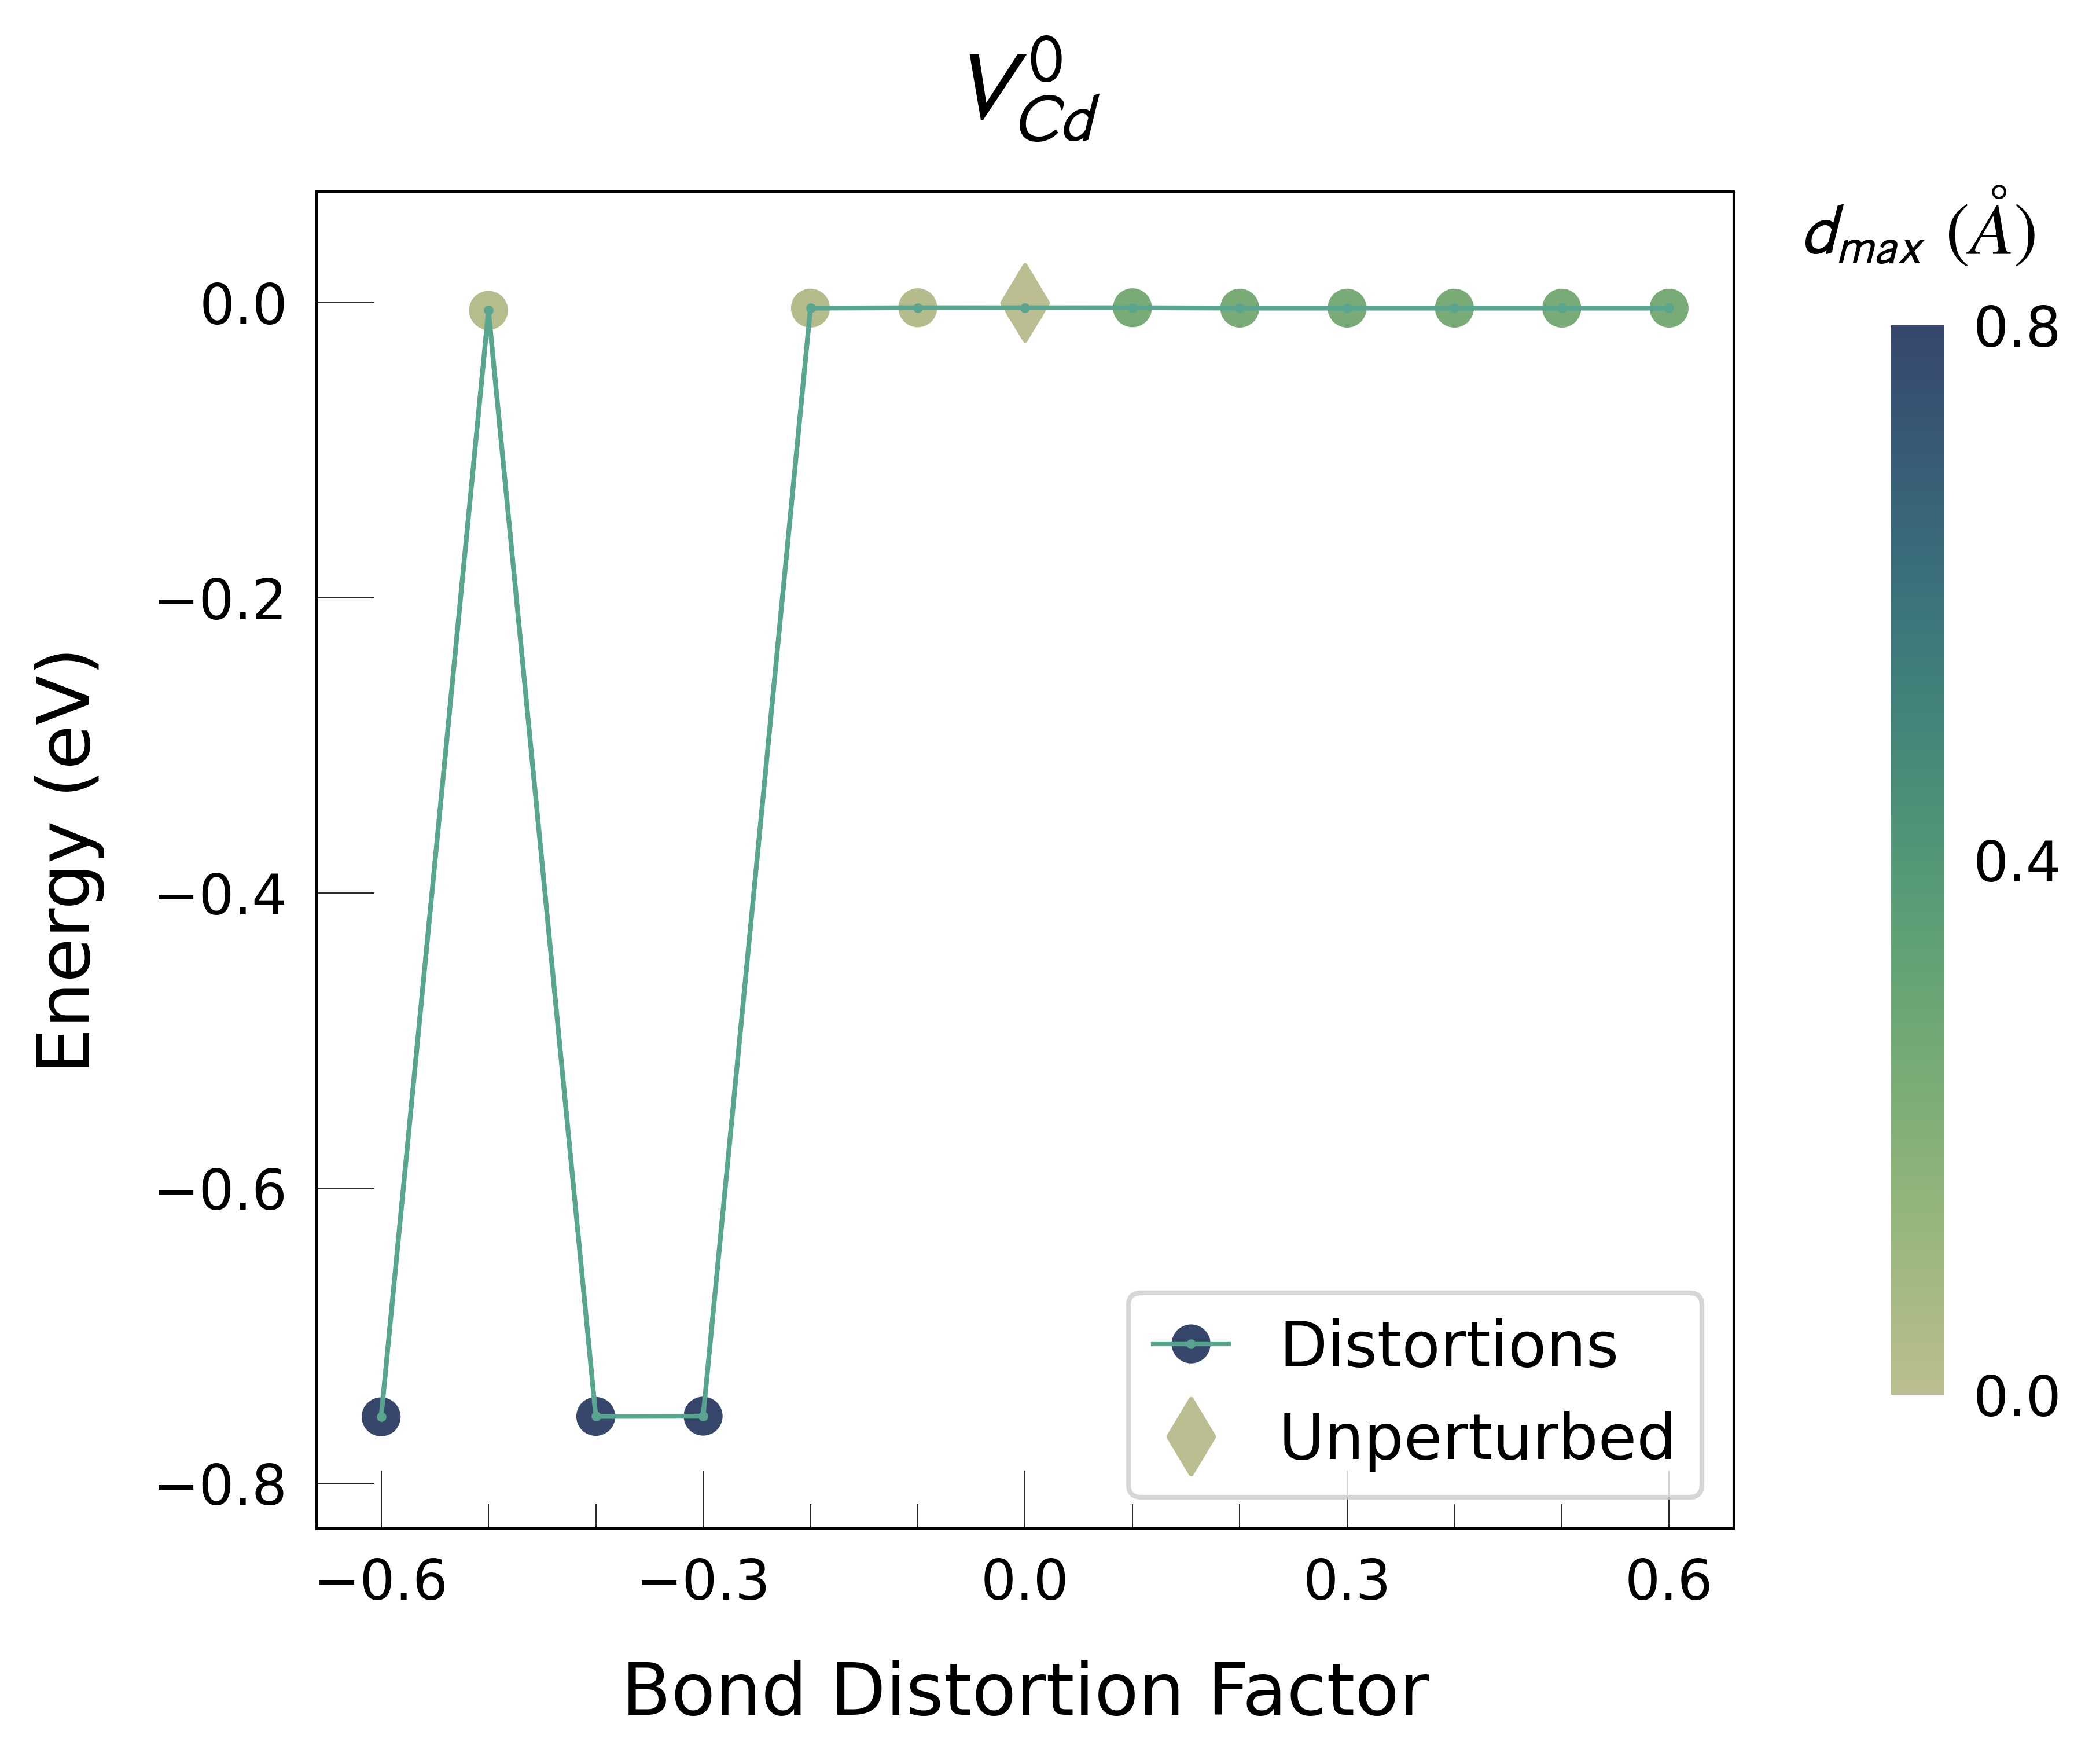

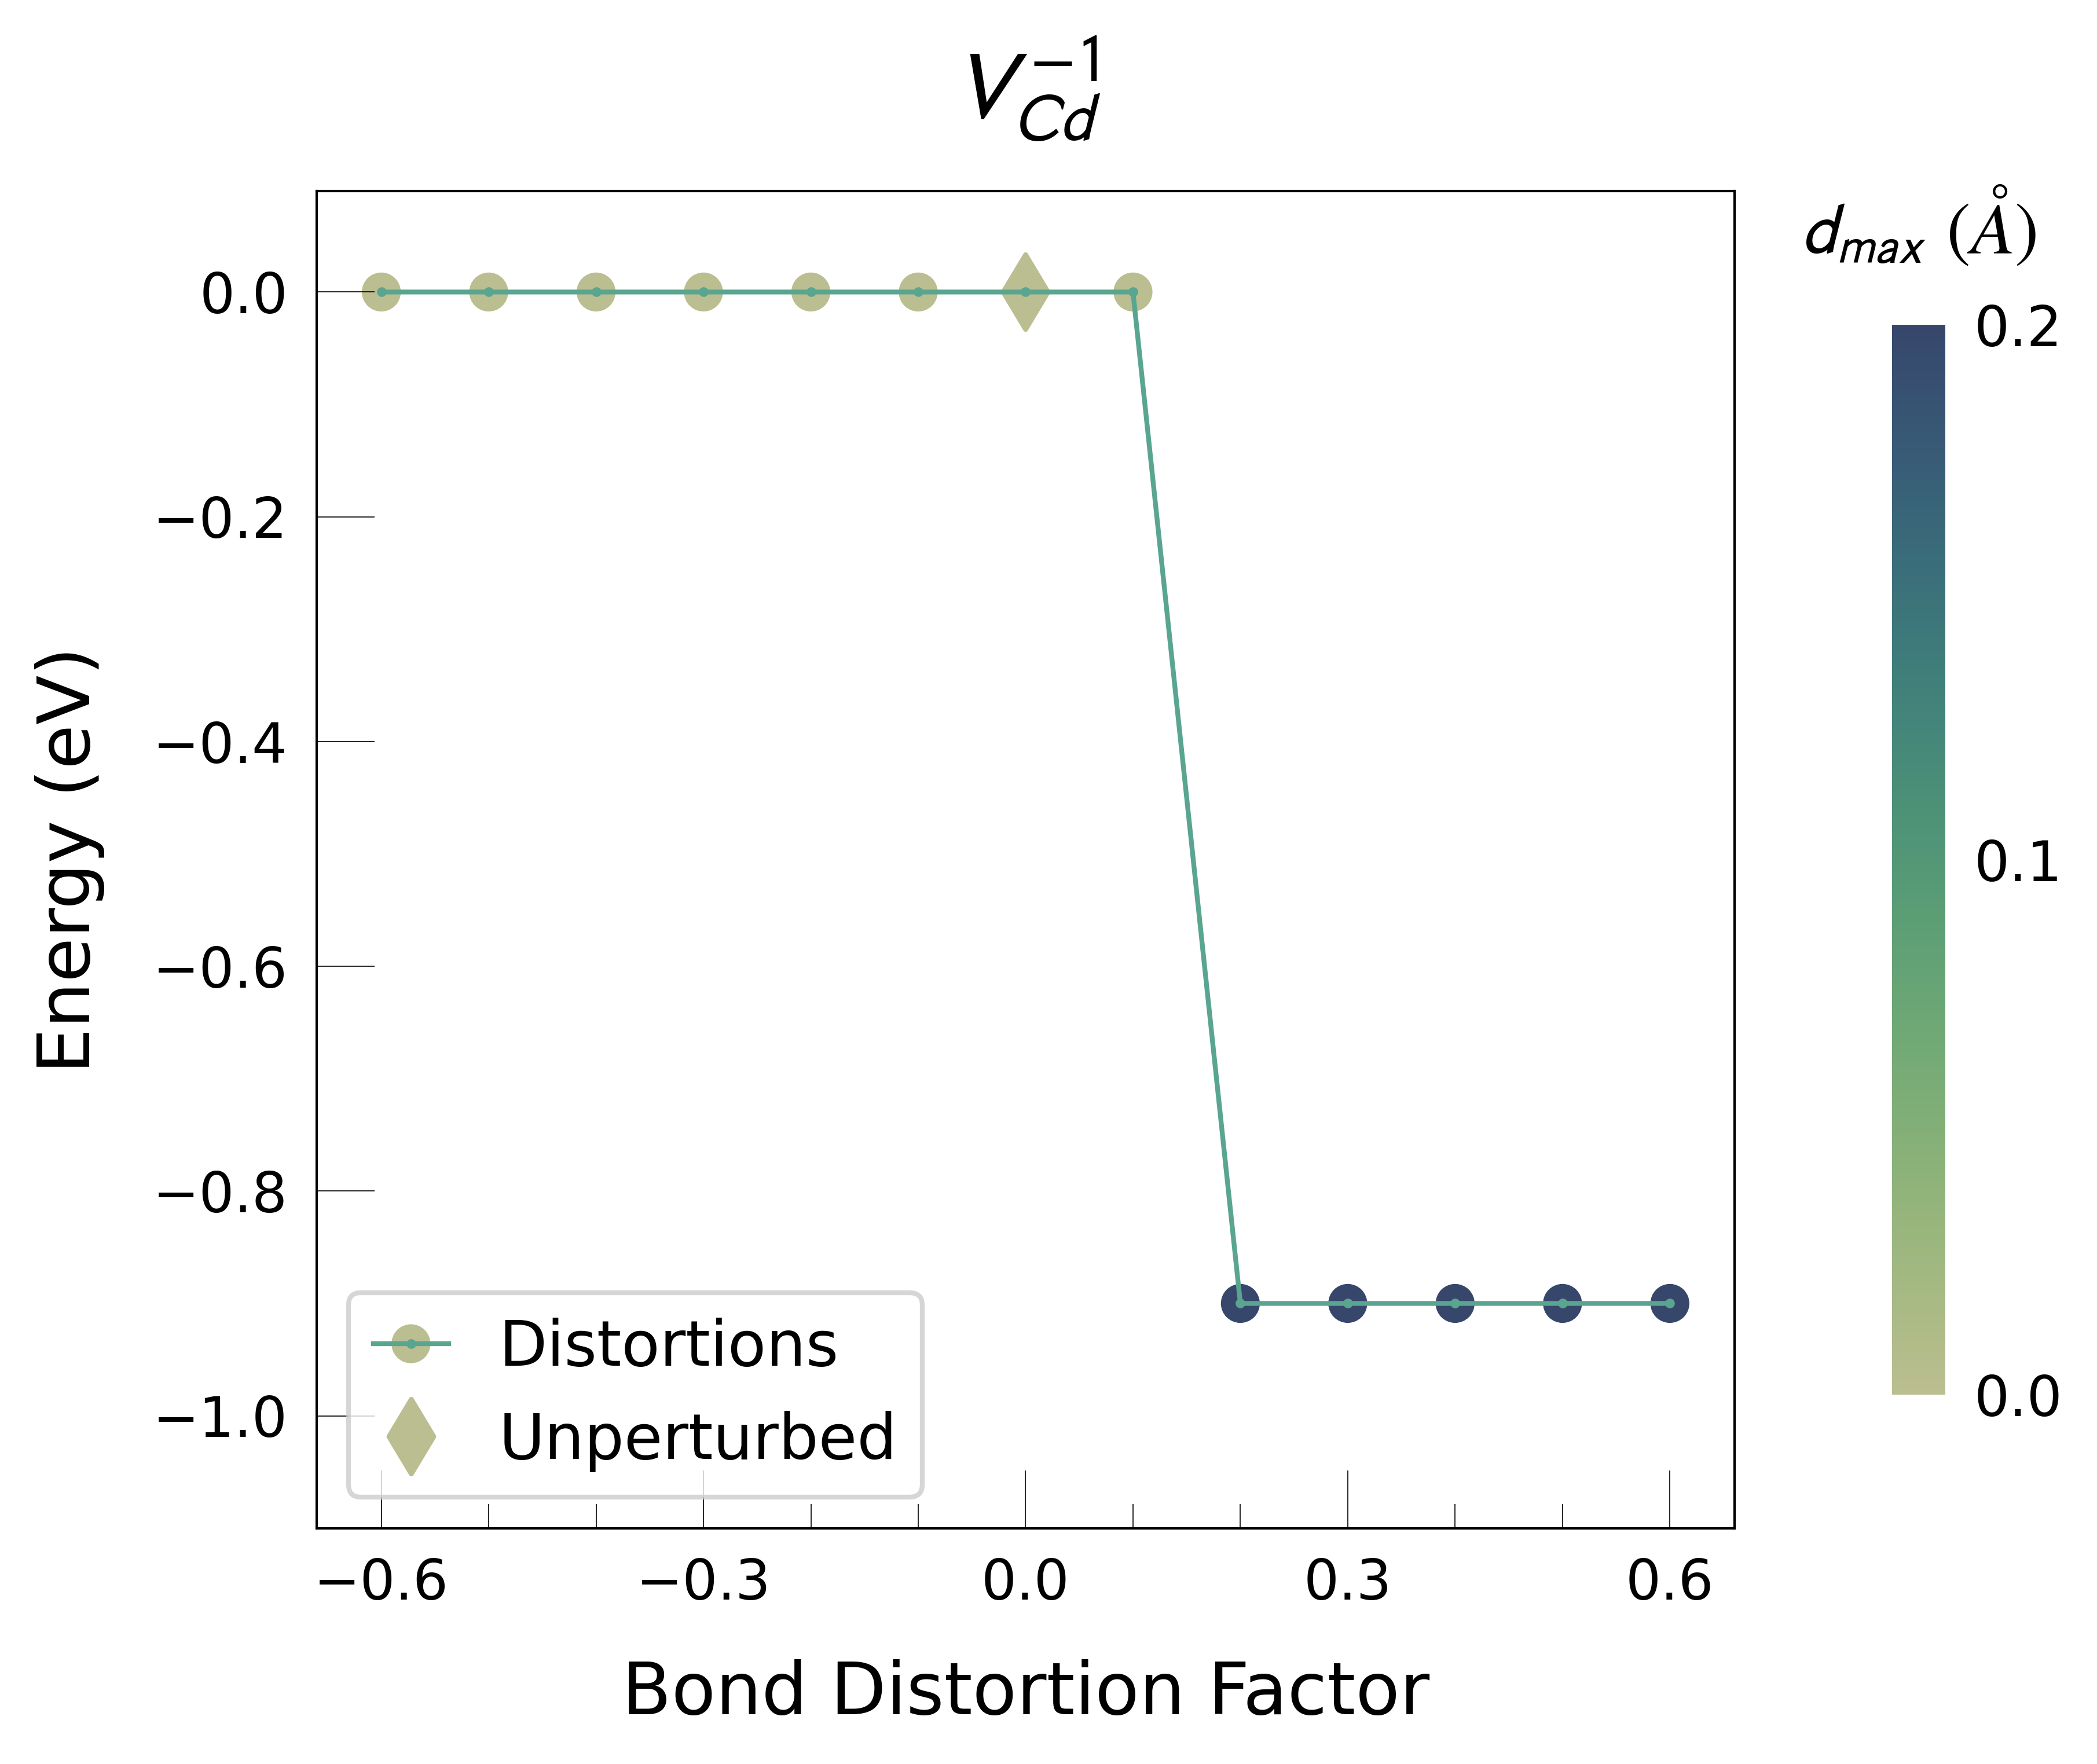

In [16]:
figs = plotting.plot_all_defects(defect_charges_dict, add_colorbar=True)

For these example results, we find energy lowering distortions for V<sub>Cd</sub><sup>0</sup> and
V<sub>Cd</sub><sup>-1</sup>.
 We should re-test these distorted structures for the V<sub>Cd</sub> charge states where these distortions were not found, in case they also give lower energies.

The `get_energy_lowering_distortions()` function above automatically performs structure comparisons to determine which distortions should be tested in other charge states of the same defect, and which have already been found (see docstring for more details).

In [17]:
# generates the new distorted structures and VASP inputs, to do our quick 2nd round of structure testing:
energy_lowering_distortions.write_retest_inputs(low_energy_defects)

Writing low-energy distorted structure to ./v_Cd_-1/Bond_Distortion_-60.0%_from_0
Writing low-energy distorted structure to ./v_Cd_-2/Bond_Distortion_-60.0%_from_0
Writing low-energy distorted structure to ./v_Cd_0/Bond_Distortion_20.0%_from_-1
Writing low-energy distorted structure to ./v_Cd_-2/Bond_Distortion_20.0%_from_-1


Again we run the calculations on the HPCs, then parse and plot the results either using the `SnB` CLI
functions, or through the python API as exemplified here.

```python
# fake example data!
import shakenbreak
snb_path = shakenbreak.__path__[0]
example_results_path = f"{snb_path}/../tests/data/example_results"

!cp {example_results_path}/v_Cd_0/v_Cd_0_additional_distortions.yaml ./v_Cd_0/v_Cd_0.yaml
!cp {example_results_path}/v_Cd_-1/v_Cd_-1_additional_distortions.yaml ./v_Cd_-1/v_Cd_-1.yaml
!cp {example_results_path}/v_Cd_-2/v_Cd_-2_additional_distortions.yaml ./v_Cd_-2/v_Cd_-2.yaml
!cp {example_results_path}/v_Cd_0/Bond_Distortion_-60.0%/CONTCAR ./v_Cd_-1/Bond_Distortion_-60.0%_from_0/
!cp {example_results_path}/v_Cd_0/Bond_Distortion_-60.0%/CONTCAR ./v_Cd_-2/Bond_Distortion_-60.0%_from_0/
!cp {example_results_path}/v_Cd_-1/Unperturbed/CONTCAR ./v_Cd_-2/Bond_Distortion_20.0%_from_-1/
!cp {example_results_path}/v_Cd_-1/Unperturbed/CONTCAR ./v_Cd_0/Bond_Distortion_20.0%_from_-1/
```

In [19]:
# re-parse with the same `get_energy_lowering_distortions()` function from before:
low_energy_defects = energy_lowering_distortions.get_energy_lowering_distortions(defect_charges_dict)


v_Cd
Parsing v_Cd_0...
v_Cd_0: Energy difference between minimum, found with -0.6 bond distortion, and unperturbed: -0.76 eV.
Energy lowering distortion found for v_Cd with charge 0. Adding to low_energy_defects dictionary.
Parsing v_Cd_-1...
v_Cd_-1: Energy difference between minimum, found with -60.0%_from_0 bond distortion, and unperturbed: -1.20 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
Low-energy distorted structure for v_Cd_-1 already found with charge states [0], storing together.
Parsing v_Cd_-2...
v_Cd_-2: Energy difference between minimum, found with 20.0%_from_-1 bond distortion, and unperturbed: -1.90 eV.
Comparing structures to specified ref_structure (Cd31 Te32)...
New (according to structure matching) low-energy distorted structure found for v_Cd_-2, adding to low_energy_defects['v_Cd'] list.

Comparing and pruning defect structures across charge states...
Ground-state structure found for v_Cd with charges [0, -1] has also been found for charge 

Finally we can replot the results from all our distortion tests:

Energy lowering distortion found for v_Cd with charge 0. Generating distortion plot...
Previous version of v_Cd_0.png found in output_path: 'v_Cd_0/'. Will rename old plot to v_Cd_0_2023-08-21-23-40.png.
Plot saved to v_Cd_0/v_Cd_0.png
Energy lowering distortion found for v_Cd with charge -1. Generating distortion plot...
Previous version of v_Cd_-1.png found in output_path: 'v_Cd_-1/'. Will rename old plot to v_Cd_-1_2023-08-21-23-40.png.
Plot saved to v_Cd_-1/v_Cd_-1.png
Energy lowering distortion found for v_Cd with charge -2. Generating distortion plot...
Plot saved to v_Cd_-2/v_Cd_-2.png


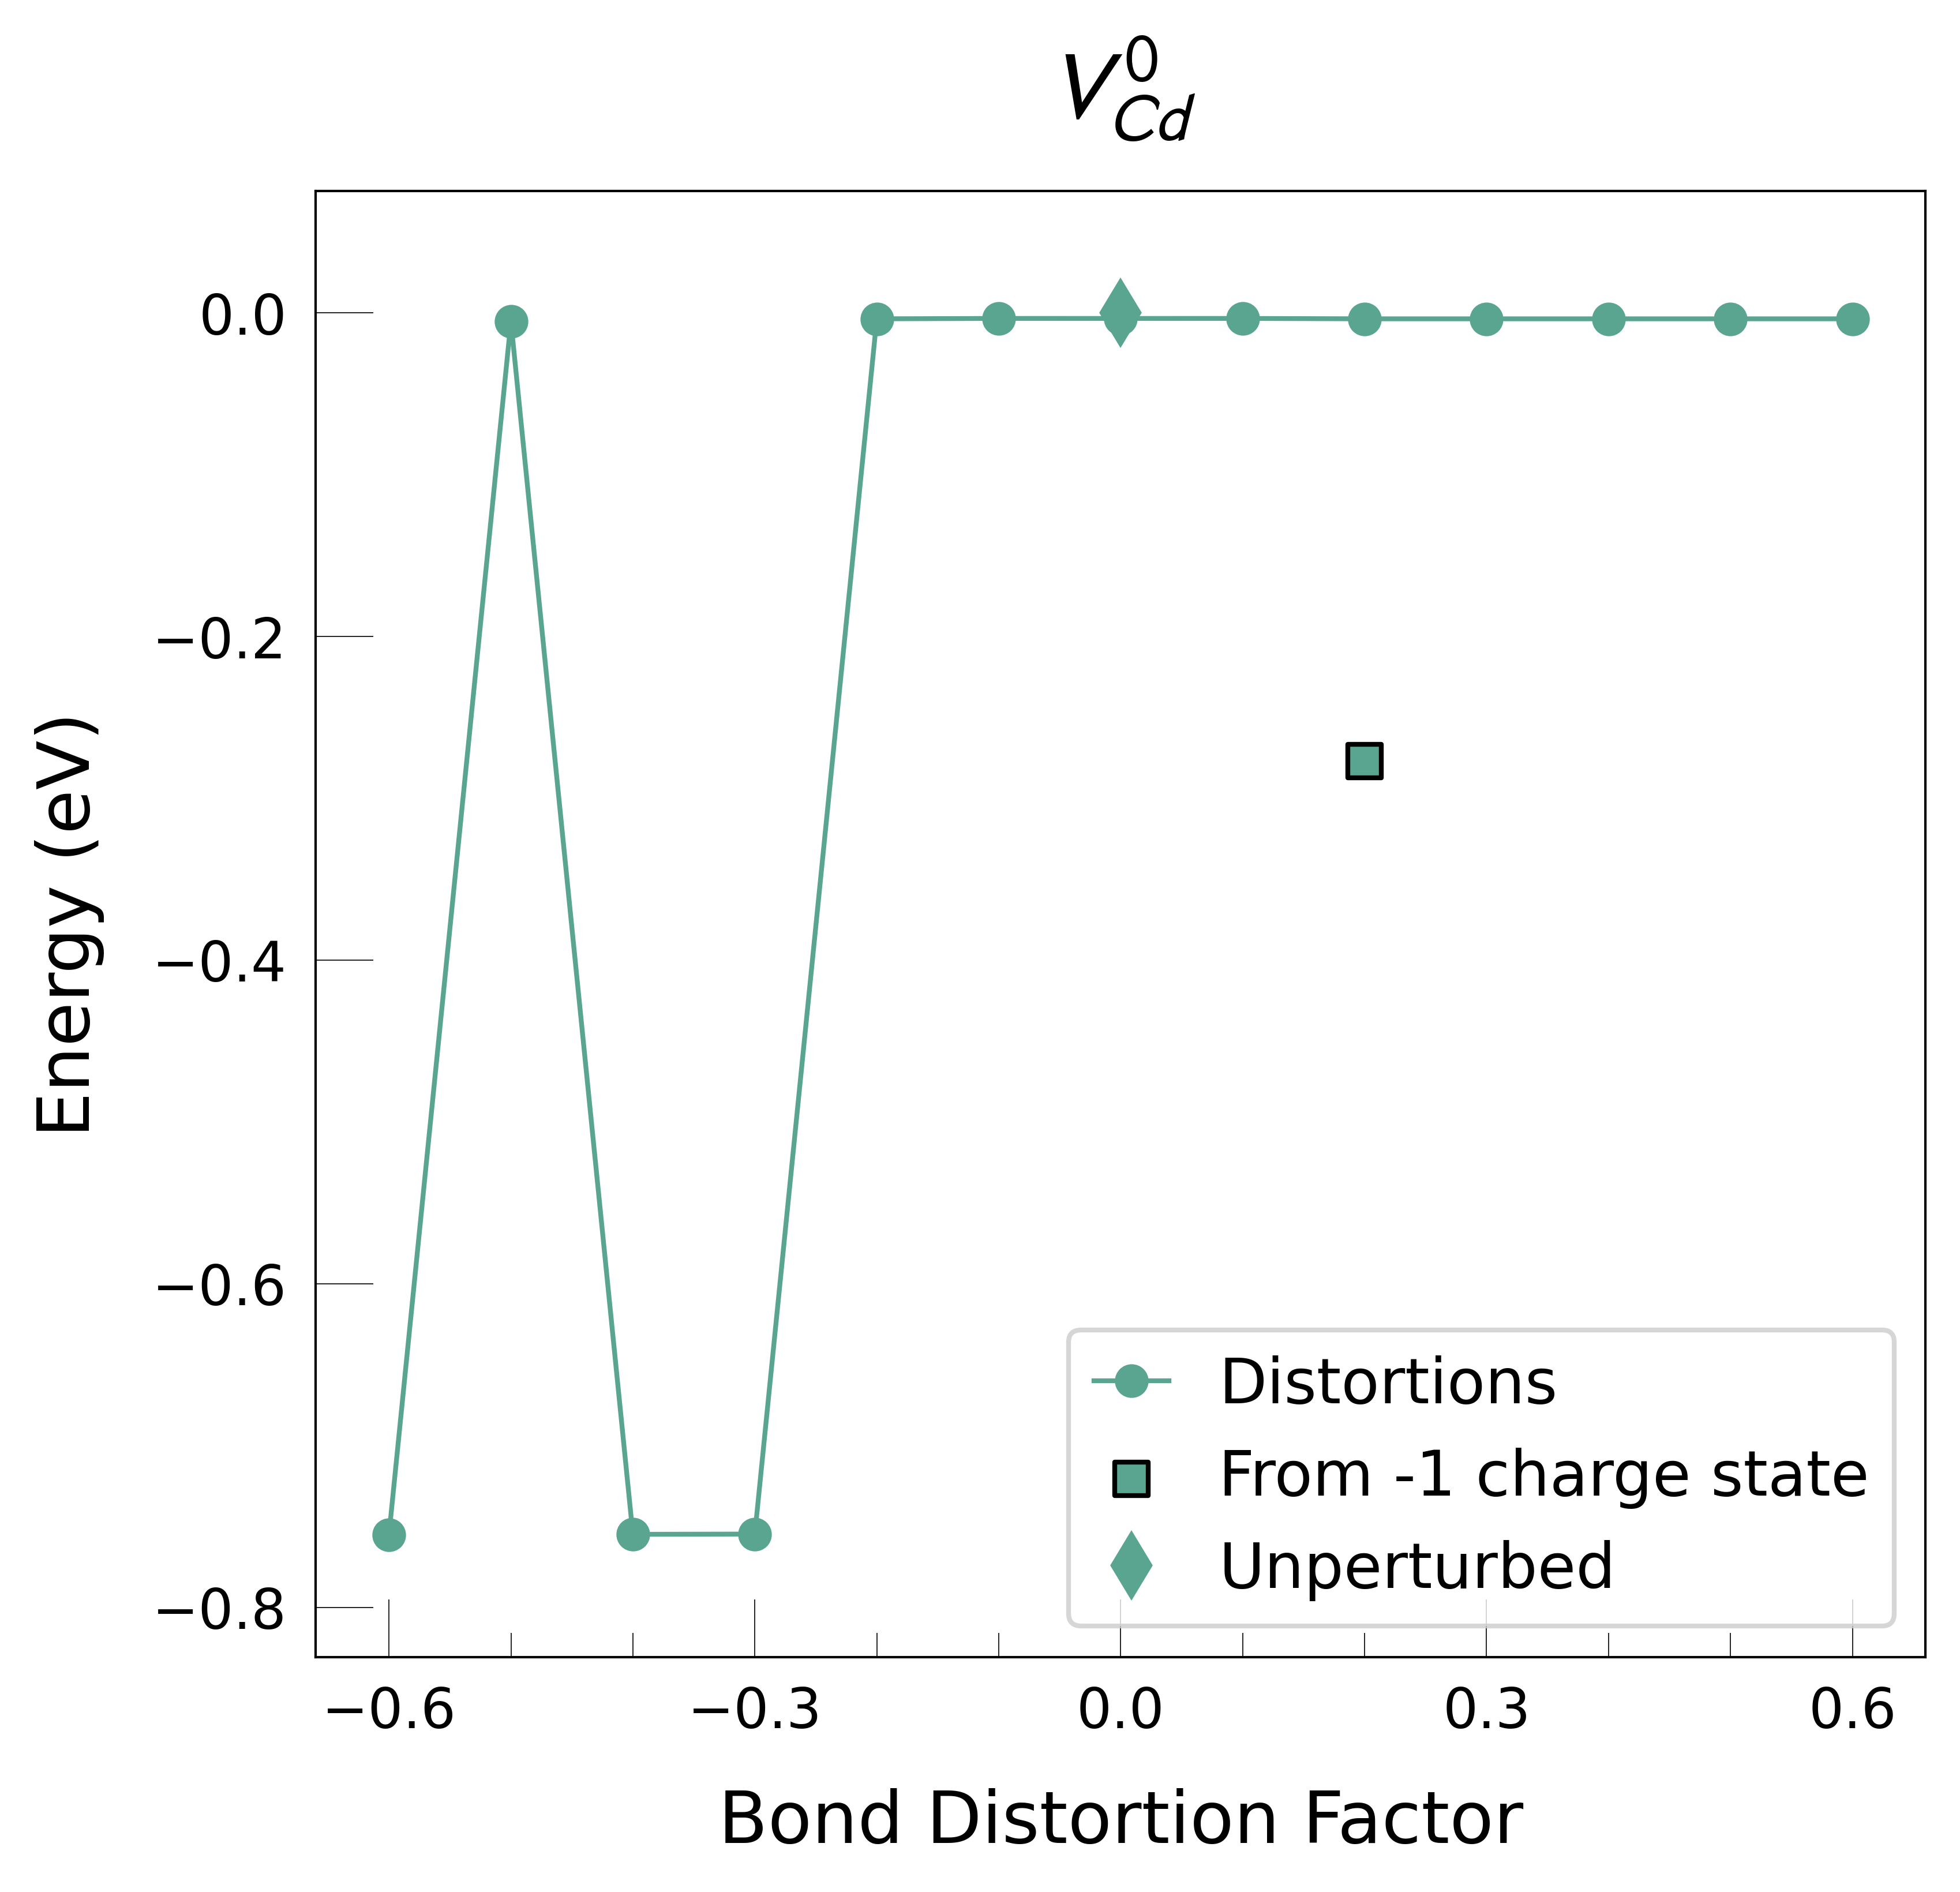

In [20]:
figs = plotting.plot_all_defects(defect_charges_dict)
figs["v_Cd_0"]

We now continue our defect calculations using the ground-state `CONTCAR`s we've obtained for each
defect, with our fully-converged `INCAR` and `KPOINTS` settings (via the `doped` `vasp.DefectsSet`
class below, to get our final defect formation energies (confident that we've identified the ground-state
defect structure!). The `energy_lowering_distortions.write_groundstate_structure()` function automatically writes these lowest-energy structures to our defect folders:

In [21]:
energy_lowering_distortions.write_groundstate_structure()

In [22]:
!head v_Cd_0/groundstate_POSCAR  # groundstate structure from -60% distortion relaxation

-60.0%_Bond__v_Cd[0. 0. 0.]_-dNELECT
   1.0000000000000000     
    13.0867679999999993    0.0000000000000000    0.0000000000000000
     0.0000000000000000   13.0867679999999993    0.0000000000000000
     0.0000000000000000    0.0000000000000000   13.0867679999999993
   Cd   Te
    31    32
Direct
  0.0014403846070577  0.0152341826280604  0.4960600473735149
  0.0018443102488570  0.5161087673464303 -0.0040398656877614


We can also optionally analyse the defect distortions found with `SnB` using the `compare_structures()`, `analyse_structure()`, `get_homoionic_bonds()` and `get_site_magnetization()` functions from `shakenbreak.analysis`; see the [distortion analysis section](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html#optional-analyse-the-defect-distortions-found-with-snb) of the [SnB Python API tutorial](https://shakenbreak.readthedocs.io/en/latest/ShakeNBreak_Example_Workflow.html) for more.

## Prepare `VASP` calculation files with `doped`

To generate our VASP input files for the defect calculations, we can use the `DefectsSet` class in the
`vasp` module of `doped`:

In [23]:
from doped.vasp import DefectsSet  # append "?" to function/class to see the help docstrings:
DefectsSet?

Init signature:
DefectsSet(
    defect_entries: Union[doped.generation.DefectsGenerator, Dict[str, pymatgen.analysis.defects.thermo.DefectEntry], List[pymatgen.analysis.defects.thermo.DefectEntry], pymatgen.analysis.defects.thermo.DefectEntry],
    soc: Optional[bool] = None,
    user_incar_settings: Optional[dict] = None,
    user_kpoints_settings: Optional[dict] = None,
    user_potcar_functional: Optional[Literal['PBE', 'PBE_52', 'PBE', 'LDA', 'LDA_52', 'LDA_54', 'PW91', 'LDA_US', 'PW91_US']] = 'PBE',
    user_potcar_settings: Optional[dict] = None,
    **kwargs,
)
Docstring:     
An object for generating input files for VASP defect calculations from
doped/pymatgen `DefectEntry` objects.
Init docstring:
Creates a dictionary of: {defect_species: DefectRelaxSet}.

DefectRelaxSet has the attributes:
- `DefectRelaxSet.vasp_gam` -> `DefectDictSet` for Gamma-point only
    relaxation. Not needed if ShakeNBreak structure searching has been
    performed (recommended), unless only Γ-point _

In [24]:
defect_set = DefectsSet(
    defect_gen,  # our DefectsGenerator object, can also input individual DefectEntry objects if desired
    user_incar_settings={"ENCUT": 350},  # custom INCAR settings, any that aren't numbers or True/False need to be input as strings with quotation marks!
)
# We can also customise the KPOINTS and POTCAR settings (and others), see the docstrings above for more info

The `DefectsSet` class prepares a dictionary in the form `{defect_species: DefectRelaxSet}`, where
`DefectRelaxSet` has attributes: `vasp_nkred_std`, `vasp_std` (if our final _k_-point sampling is
non-Γ-only with multiple _k_-points), `vasp_ncl` (if SOC included; see docstrings for default behaviour)
and/or `vasp_gam` (if our final _k_-point sampling is Γ-only).
These attributes are `DefectDictSet` objects, subclasses of the `pymatgen` `DictSet` object, and contain
 information about the calculation inputs.

In [36]:
defect_set.defect_sets

{'v_Cd_-2': <doped.vasp.DefectRelaxSet at 0x139f8c160>,
 'v_Cd_-1': <doped.vasp.DefectRelaxSet at 0x139f8caf0>,
 'v_Cd_0': <doped.vasp.DefectRelaxSet at 0x139f8ca60>,
 'v_Cd_+1': <doped.vasp.DefectRelaxSet at 0x139f8f160>,
 'v_Te_-1': <doped.vasp.DefectRelaxSet at 0x139f8f580>,
 'v_Te_0': <doped.vasp.DefectRelaxSet at 0x139e82260>,
 'v_Te_+1': <doped.vasp.DefectRelaxSet at 0x139e83370>,
 'v_Te_+2': <doped.vasp.DefectRelaxSet at 0x139e82290>,
 'Cd_Te_0': <doped.vasp.DefectRelaxSet at 0x139e82380>,
 'Cd_Te_+1': <doped.vasp.DefectRelaxSet at 0x139e823b0>,
 'Cd_Te_+2': <doped.vasp.DefectRelaxSet at 0x139e82a40>,
 'Cd_Te_+3': <doped.vasp.DefectRelaxSet at 0x139e82bf0>,
 'Cd_Te_+4': <doped.vasp.DefectRelaxSet at 0x139e82c50>,
 'Te_Cd_-4': <doped.vasp.DefectRelaxSet at 0x139e823e0>,
 'Te_Cd_-3': <doped.vasp.DefectRelaxSet at 0x139e82a10>,
 'Te_Cd_-2': <doped.vasp.DefectRelaxSet at 0x139e83580>,
 'Te_Cd_-1': <doped.vasp.DefectRelaxSet at 0x139e83160>,
 'Te_Cd_0': <doped.vasp.DefectRelaxSet at 

In [46]:
# for example, let's look at the generated inputs for a `vasp_std` calculation with `NKRED`, for Cd_Te_+2:
print(f"INCAR:\n{defect_set.defect_sets['Cd_Te_+2'].vasp_nkred_std.incar}")
print(f"KPOINTS:\n{defect_set.defect_sets['Cd_Te_+2'].vasp_nkred_std.kpoints}")
print(f"POTCAR (symbols):\n{defect_set.defect_sets['Cd_Te_+2'].vasp_nkred_std.potcar_symbols}")

INCAR:
# May want to change NCORE, KPAR, AEXX, ENCUT, NUPDOWN, ISPIN, POTIM = Typical variable parameters
AEXX = 0.25
ALGO = Normal  # change to all if zhegv, fexcp/f or zbrent errors encountered
EDIFF = 1e-05
EDIFFG = -0.01
ENCUT = 350
GGA = Pe
HFSCREEN = 0.208
IBRION = 2
ICHARG = 1
ICORELEVEL = 0  # needed if using the kumagai-oba (efnv) anisotropic charge correction scheme
ISIF = 2
ISMEAR = 0
ISPIN = 2
ISYM = 0  # symmetry breaking extremely likely for defects
KPAR = 2
LASPH = True
LHFCALC = True
LMAXMIX = 4
LORBIT = 11
LREAL = Auto
LVHAR = True
NCORE = 16
NEDOS = 2000
NELECT = 580.0
NKRED = 2
NSW = 200
NUPDOWN = 0
PREC = Accurate
PRECFOCK = Fast
SIGMA = 0.05

KPOINTS:
KPOINTS from doped, with reciprocal_density = 100/Å⁻³
0
Gamma
2 2 2

POTCAR (symbols):
['Cd', 'Te']


```{tip}
The use of (subclasses of) `pymatgen` `DictSet` objects here allows these functions to be readily used with high-throughput frameworks such as `atomate(2)` or `AiiDA`.
```

We can then write these files to disk with the `write_files()` method:

In [51]:
defect_set.write_files()  # again add "?" to see the docstring and options

Generating and writing input files: 100%|██████████| 50/50 [00:18<00:00,  2.75it/s]


```{note}
The recommended defects workflow is to use the `ShakeNBreak` approach with the initial generated defect configurations, which allows us to identify the ground-state structures and also accelerates the defect calculations by performing the initial fast `vasp_gam` relaxations, which 'pre-converge' our structures by bringing us very close to the final converged relaxed structure, much quicker (10-100x) than if we performed the fully-converged `vasp_std` relaxations from the beginning.

As such, `DefectsSet.write_files()` assumes by default that the defect structures (`POSCAR`s) have
already been generated and pre-relaxed with `ShakeNBreak`, and that you will then copy in the
`groundstate` `POSCAR`s (as shown above) to continue with the final defect relaxations in these folders.
If for some reason you are not following this recommended approach, you can either set `vasp_gam = True`
 in `write_files()` to generate the unperturbed defect structures and input files for `vasp_gam`
relaxations, or you can use `unperturbed_poscar = True` to also write the unperturbed defect `POSCAR`s
to the defect folders.
```

In [61]:
!ls *Cd_i*/*vasp* # list the generated VASP input files

Cd_i_C3v_+1/vasp_ncl:
Cd_i_C3v_+1.json INCAR            KPOINTS          POTCAR

Cd_i_C3v_+1/vasp_nkred_std:
Cd_i_C3v_+1.json INCAR            KPOINTS          POTCAR

Cd_i_C3v_+1/vasp_std:
Cd_i_C3v_+1.json INCAR            KPOINTS          POTCAR

Cd_i_C3v_+2/vasp_ncl:
Cd_i_C3v_+2.json INCAR            KPOINTS          POTCAR

Cd_i_C3v_+2/vasp_nkred_std:
Cd_i_C3v_+2.json INCAR            KPOINTS          POTCAR

Cd_i_C3v_+2/vasp_std:
Cd_i_C3v_+2.json INCAR            KPOINTS          POTCAR

Cd_i_C3v_0/vasp_ncl:
Cd_i_C3v_0.json INCAR           KPOINTS         POTCAR

Cd_i_C3v_0/vasp_nkred_std:
Cd_i_C3v_0.json INCAR           KPOINTS         POTCAR

Cd_i_C3v_0/vasp_std:
Cd_i_C3v_0.json INCAR           KPOINTS         POTCAR

Cd_i_Td_Cd2.83_+1/vasp_ncl:
Cd_i_Td_Cd2.83_+1.json KPOINTS
INCAR                  POTCAR

Cd_i_Td_Cd2.83_+1/vasp_nkred_std:
Cd_i_Td_Cd2.83_+1.json KPOINTS
INCAR                  POTCAR

Cd_i_Td_Cd2.83_+1/vasp_std:
Cd_i_Td_Cd2.83_+1.json KPOINTS
INCAR               

We can see that for each defect species, we have a `vasp_nkred_std`, `vasp_std` and `vasp_ncl` folder
with corresponding VASP input files. This follows our recommended defect workflow (see the [YouTube
defects tutorial](https://doped.readthedocs.io/en/latest/YT_defects_tutorial.html), which is to first
perform defect structure-searching with `ShakeNBreak` using `vasp_gam`, then copy in the `groundstate`
`POSCAR`s to continue the defect relaxations with `vasp_std` (multiple _k_-points) but using `NKRED` to
reduce the cost of hybrid DFT calculations (typically good accuracy for forces)(-> `vasp_nkred_std`
input files), then without `NKRED` (-> `vasp_std` folder), then if SOC is important (which it is in this
 case for CdTe) we do a final SOC singlepoint calculation with `vasp_ncl`.

Our `Groundstate` `POSCAR`s from `ShakeNBreak` can be quickly copied to the generated defect folders
with something like:
```bash
for defect in ./*_{+,-}[0-9]/; do cd $defect; cp groundstate_POSCAR vasp_std/POSCAR; cd ..; done
```

In [55]:
!cat v_Te_0/vasp_nkred_std/INCAR

# May want to change NCORE, KPAR, AEXX, ENCUT, NUPDOWN, ISPIN, POTIM = Typical variable parameters
AEXX = 0.25
ALGO = Normal  # change to all if zhegv, fexcp/f or zbrent errors encountered
EDIFF = 1e-05
EDIFFG = -0.01
ENCUT = 350
GGA = Pe
HFSCREEN = 0.208
IBRION = 2
ICHARG = 1
ICORELEVEL = 0  # needed if using the kumagai-oba (efnv) anisotropic charge correction scheme
ISIF = 2
ISMEAR = 0
ISPIN = 2
ISYM = 0  # symmetry breaking extremely likely for defects
KPAR = 2
LASPH = True
LHFCALC = True
LMAXMIX = 4
LORBIT = 11
LREAL = Auto
LVHAR = True
NCORE = 16
NEDOS = 2000
NELECT = 570.0
NKRED = 2
NSW = 200
NUPDOWN = 0
PREC = Accurate
PRECFOCK = Fast
SIGMA = 0.05


```{note}
The `NELECT` `INCAR` tag (-> number of electrons, sets the defect charge state in the calculation) is
automatically determined based on the choice of `POTCAR`s. The default in both `doped` and `ShakeNBreak`
 is to use the [`MPRelaxSet` `POTCAR` choices](https://github.com/materialsproject/pymatgen/blob/master/pymatgen/io/vasp/MPRelaxSet.yaml), but if
you're using different ones, make sure to set `potcar_settings` in the `VASP` file generation functions,
 so that `NELECT` is then set accordingly. This requires the `pymatgen` config file `$HOME/.pmgrc.yaml`
to be properly set up as detailed on the [Installation docs page](https://doped.readthedocs.io/en/latest/Installation.html)
```

As well as the `INCAR`, `POTCAR` and `KPOINTS` files for each calculation in the defects workflow, we
also see that a `{defect_species}.json` file is created by default, which contains the corresponding
`DefectEntry` python object, which can later be reloaded with `DefectEntry.from_json()` (useful if we
later want to recheck some of the defect generation info).
The `DefectsGenerator` object is also saved to `JSON` by default here, which can be reloaded with
`DefectsGenerator.from_json()`.

A folder with the input files for calculating the reference bulk (pristine, defect-free) supercell is also
generated (this calculation is needed to later compute defect formation energies and charge corrections):

In [57]:
!ls CdTe_bulk/vasp_ncl  # only the final workflow VASP calculation is required for the bulk, see docstrings

INCAR   KPOINTS POSCAR  POTCAR


## Chemical Potentials
As well as performing our defect supercell calculations, we also need to compute the chemical potentials
 of the elements in our system, in order to later calculate the defect formation energies. For more
 information on this, see our defect calculations tutorial [video](https://youtu.be/FWz7nm9qoNg) and/or this useful quick-start guide article on defect calculations [here](https://iopscience.iop.org/article/10.1088/2515-7655/aba081).

The workflow for computing and analysing the chemical potentials is described in the [Competing Phases](https://doped.readthedocs.io/en/latest/dope_chemical_potentials.html) tutorial.